In [167]:
import numpy as np
import importlib
import matplotlib as mpl
import matplotlib.pylab as plt
import time
from copy import deepcopy
import torch

from stg_energy.common import col, svg, samples_nd, get_labels_8pt
from stg_energy.fig5_cc.viz import vis_sample_plain
from pyloric.sbi_prior import create_prior, create_prior_general
from pyloric.sbi_wrapper import simulate, simulate_general, load_setup, get_time, stats
from stg_energy.fig7_temp.process_samples import merge_samples
import stg_energy.fig7_temp.viz

from stg_energy.fig2_histograms.energy import select_ss_close_to_obs

# Fig 7: posterior over temperatures
Results are the same as in my MSc thesis. This means that they were created with delfi, and they are on a different lobster.

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
PANEL_A1 = 'svg/panel_a1.svg'
PANEL_A2 = 'svg/panel_a2.svg'
PANEL_A3 = 'svg/panel_a3.svg'
PANEL_A4 = 'svg/panel_a4.svg'
PANEL_A5 = 'svg/panel_a5.svg'

PANEL_B1 = 'svg/panel_b1.svg'
PANEL_B2 = 'svg/panel_b2.svg'
PANEL_B3 = 'svg/panel_b3.svg'
PANEL_B4 = 'svg/panel_b4.svg'
PANEL_B5 = 'svg/panel_b5.svg'

PANEL_C1 = 'svg/panel_c1.svg'
PANEL_C2 = 'svg/panel_c2.svg'
PANEL_C3 = 'svg/panel_c3.svg'
PANEL_C4 = 'svg/panel_c4.svg'
PANEL_C5 = 'svg/panel_c5.svg'

PANEL_D1 = 'svg/panel_d1.svg'
PANEL_D2 = 'svg/panel_d2.svg'
PANEL_D3 = 'svg/panel_d3.svg'
PANEL_D4 = 'svg/panel_d4.svg'
PANEL_D5 = 'svg/panel_d5.svg'

PANEL_X1 = 'svg/panel_x1.svg'
PANEL_X2 = 'svg/panel_x2.svg'
PANEL_X3 = 'svg/panel_x3.svg'

PANEL_suppA = 'svg/panel_supp_a.svg'

In [42]:
prior = create_prior(log=True)
dimensions_11 = 31
lims_11 = np.asarray([-np.sqrt(3)*np.ones(dimensions_11), np.sqrt(3)*np.ones(dimensions_11)]).T 
dimensions_15 = 46
lims_15 = np.asarray([-np.sqrt(3)*np.ones(dimensions_15), np.sqrt(3)*np.ones(dimensions_15)]).T

### Load samples from 11 deg, 15deg, 19deg, 23deg, 27deg

In [43]:
data = np.load("../../results/11deg_post_pred/11_deg_post_pred.npz")
sample_params_11 = data["params"]

In [44]:
data = np.load("../../results/temperature/sbi/15deg_uncond/posterior_samples/params_0.npz")
sample_params_15 = data["conductance_params"]

In [45]:
data = np.load("../../results/temperature/sbi/19deg_uncond/posterior_samples/params_0.npz")
sample_params_19 = data["conductance_params"]

In [46]:
data = np.load("../../results/temperature/sbi/23deg_uncond/posterior_samples/params_0.npz")
sample_params_23 = data["conductance_params"]

In [47]:
data = np.load("../../results/temperature/sbi/27deg_uncond/posterior_samples/params_0.npz")
sample_params_27 = data["conductance_params"]

# Plot posteriors

In [48]:
sample_params_15.shape

(2520, 41)

In [56]:
prior = create_prior()
lims = torch.cat((prior.support.lower_bound.unsqueeze(0), prior.support.upper_bound.unsqueeze(0)), dim=0).T

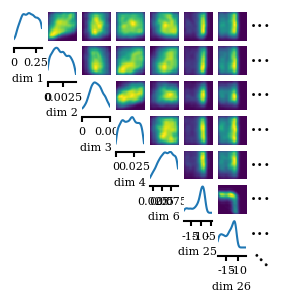

In [67]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    _ = samples_nd(
        samples=sample_params_11[:2520],
        subset=[0,1,2,3,5,24,25],
        limits=lims,
        upper=['kde'],
        diag=['kde'],
        fig_size=(3,3),
    )

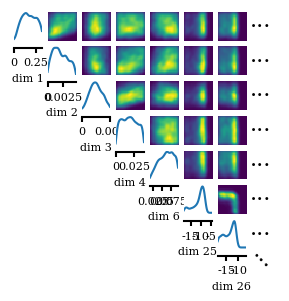

In [68]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    _ = samples_nd(
        samples=sample_params_15[:2520],
        subset=[0,1,2,3,5,24,25],
        limits=lims,
        upper=['kde'],
        diag=['kde'],
        fig_size=(3,3),
    )

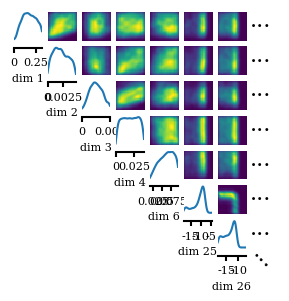

In [69]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    _ = samples_nd(
        samples=sample_params_19[:2520],
        subset=[0,1,2,3,5,24,25],
        limits=lims,
        upper=['kde'],
        diag=['kde'],
        fig_size=(3,3),
    )

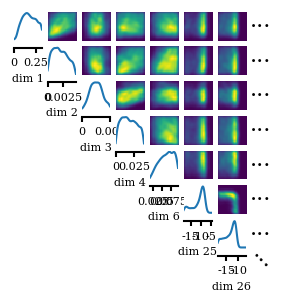

In [70]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    _ = samples_nd(
        samples=sample_params_23[:2520],
        subset=[0,1,2,3,5,24,25],
        limits=lims,
        upper=['kde'],
        diag=['kde'],
        fig_size=(3,3),
    )

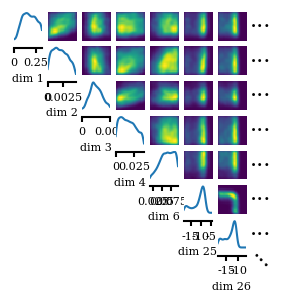

In [71]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    _ = samples_nd(
        samples=sample_params_27[:2520],
        subset=[0,1,2,3,5,24,25],
        limits=lims,
        upper=['kde'],
        diag=['kde'],
        fig_size=(3,3),
    )

In [79]:
from parameters import ParameterSet
setups_dict = ParameterSet('/home/michael/Documents/pyloric/pyloric/setups.prm')
hyperparams_11 = setups_dict['collect_samples_15deg_energy_ssRanges']

### Temperature: 27deg. Check how many samples from 11deg, 15deg,..., 27deg posterior produce no NaN
This is rather just a sanity check

In [127]:
hyperparams_11.model_params.temp = 299

In [128]:
general_prior = create_prior_general(hyperparams_11)

In [129]:
sims_per_dataset = 50
num_good_in_dataset = []
for dataset_temp in [sample_params_11, sample_params_15, sample_params_19, sample_params_23, sample_params_27]:
    print("New dataset")
    counter_good = 0
    for sample_ind in range(sims_per_dataset):
        if dataset_temp.shape[1] == 31:
            q10 = general_prior.sample((1,)).numpy()[0, -10:]
            parameter_set = np.concatenate((dataset_temp[sample_ind].astype(np.float64), q10),)
        else:
            parameter_set = dataset_temp[sample_ind].astype(np.float64)
        out_target = simulate_general(
            deepcopy(parameter_set),
            hyperparams_11,
            seed=0,
        )
        ss = stats(out_target)
        if np.invert(np.any(np.isnan(ss[:15]))):
            counter_good += 1
    num_good_in_dataset.append(counter_good)
print("Percentage of good samples for 11, 15, 19, 23, 27 degree posteriors:", np.asarray(num_good_in_dataset)/sims_per_dataset*100)

New dataset
New dataset
New dataset
New dataset
New dataset
Percentage of good samples for 11, 15, 19, 23, 27 degree posteriors: [32. 26. 28. 52. 82.]


# Plot a sample from the 27deg posterior across temperatures

/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


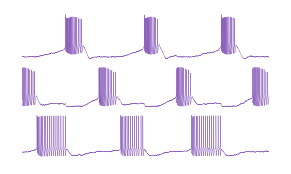

/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


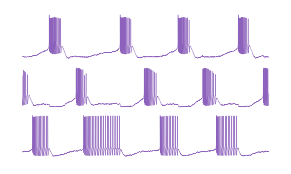

/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


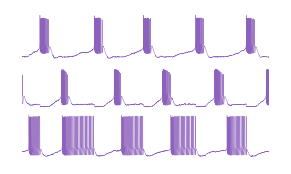

/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


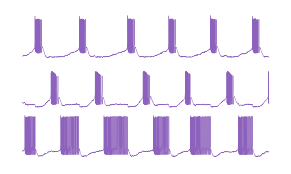

/home/michael/anaconda3/envs/sbi_prinz/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


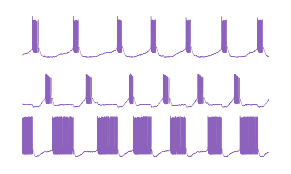

In [132]:
sample_index = 0
parameter_set = sample_params_27[sample_index].astype(np.float64)

for temp in [283, 287, 291, 295, 299]:

    hyperparams_11.model_params.temp = temp

    out_target = simulate_general(
        deepcopy(parameter_set),
        hyperparams_11,
        seed=0,
    )

    with mpl.rc_context(fname="../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(3.5, 2.0))
        fig = vis_sample_plain(
            out_target,
            get_time(),
            ax,
            time_len=150000,
            col=col["CONSISTENT1"],
            scale_bar=False,
        )
        plt.show()

# Relation between energy efficiency and temperature robustness

In [207]:
outfile = '../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz'
data_n = np.load(outfile)
# sample_seeds_11 = data_n["seeds"]
sample_params_11 = data_n["sample_params"]
sample_stats_11 = data_n["sample_stats"]
print('There are', len(sample_params_11), 'datapoints in this dataset')

There are 55043 datapoints in this dataset


In [208]:
outfile = '../../results/temperature/sbi/27deg_post_pred/27_deg_post_pred.npz'
data_n = np.load(outfile)
sample_params_27 = data_n["params"]
sample_stats_27 = data_n["stats"]
sample_seeds_27 = data_n["seeds"]
print('There are', len(sample_params_27), 'datapoints in this dataset')

There are 1205594 datapoints in this dataset


In [209]:
npz = np.load("../../results/experimental_data/summstats_prep845_082_0044.npz")
observation = npz["summ_stats"]

npz = np.load("../../results/experimental_data/trace_data_845_082_0044.npz")
t = npz["t"]

In [210]:
num_std = np.asarray(
    [0.02, 0.02, 0.02, 0.02, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
)

In [211]:
datafile = "../../results/prior_samples_after_classifier/samples_full_3.npz"
data = np.load(datafile)

params = data["params"]
stats = data["stats"]
seeds = data["seeds"]

stats_mean = np.mean(stats, axis=0)
stats_std = np.std(stats, axis=0)

In [212]:
sample_params_27.shape

(1205594, 31)

In [213]:
good_params, good_dat, good_seeds = select_ss_close_to_obs(
    sample_params_27,
    sample_stats_27,
    sample_seeds_27,
    observation,
    num_std=num_std,
    stats_std=stats_std[:15],
)

In [214]:
# np.savez('../../results/temperature/sbi/27deg_post_pred/27_deg_post_pred_close_to_obs.npz', sample_params=good_params, sample_stats=good_dat, sample_seeds=good_seeds)

In [215]:
data_27 = np.load('../../results/temperature/sbi/27deg_post_pred/27_deg_post_pred_close_to_obs.npz')
sample_params_27 = data_27['sample_params']
sample_stats_27 = data_27['sample_stats']
sample_seeds_27 = data_27['sample_seeds']

### TODO: make sure that we reject for 27deg

In [218]:
sample_stats_27 = sample_stats_27[:40000]
sample_stats_11 = sample_stats_11[:40000]

In [219]:
all_energies_per_spike_11 = sample_stats_11[:, 18:21]
all_total_energies_11 = sample_stats_11[:, 21:24]

all_energies_per_spike_27 = sample_stats_27[:, 18:21]
all_total_energies_27 = sample_stats_27[:, 21:24]

In [220]:
summed_energies_per_spike_11 = np.sum(np.asarray(all_energies_per_spike_11), axis=1)
summed_energies_total_11 = np.sum(np.asarray(all_total_energies_11), axis=1)

summed_energies_per_spike_27 = np.sum(np.asarray(all_energies_per_spike_27), axis=1)
summed_energies_total_27 = np.sum(np.asarray(all_total_energies_27), axis=1)

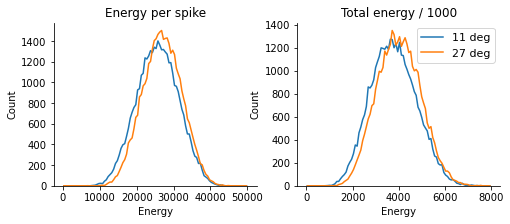

In [221]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
hist_vals_11 = ax[0].hist(summed_energies_per_spike_11, range=[0, 50000], bins=100, color='w')
hist_vals_27 = ax[0].hist(summed_energies_per_spike_27, range=[0, 50000], bins=100, color='w')

hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
ax[0].plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0])
ax[0].plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0])
ax[0].set_ylabel('Count', fontsize=10.0)
ax[0].set_xlabel('Energy', fontsize=10.0)
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Energy per spike', fontsize=12.0)

hist_vals_11 = ax[1].hist(summed_energies_total_11/1000, range=[0, 8000], bins=100, color='w')
hist_vals_27 = ax[1].hist(summed_energies_total_27/1000, range=[0, 8000], bins=100, color='w')

hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
line11 = ax[1].plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0])
line27 = ax[1].plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0])
ax[1].set_ylabel('Count', fontsize=10.0)
ax[1].set_xlabel('Energy', fontsize=10.0)
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Total energy / 1000', fontsize=12.0)

plt.legend((line11[0], line27[0]), ('11 deg', '27 deg'), fontsize=11.)

# Compose figure

In [222]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [223]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "11.4cm",
    
    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", 0.0*factor_svg, 2.6*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig7.svg")
svg('../fig/fig7.svg')

FileNotFoundError: [Errno 2] No such file or directory: './svg/panel_c1.svg'